In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from math import ceil
import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('../utils/')
from data_utils import get_folders
from train_utils import train
from diagnostic_tools import count_params
    
torch.cuda.is_available()

True

In [3]:
torch.backends.cudnn.benchmark = True

# Create data iterators

In [4]:
batch_size = 128

In [5]:
train_folder, val_folder = get_folders()

train_iterator = DataLoader(
    train_folder, batch_size=batch_size, num_workers=4,
    shuffle=True, pin_memory=True
)

val_iterator = DataLoader(
    val_folder, batch_size=256, num_workers=4,
    shuffle=False, pin_memory=True
)

# number of training samples
train_size = len(train_folder.imgs)
train_size

100000

In [6]:
# number of validation samples
val_size = len(val_folder.imgs)
val_size

10000

# Model

In [7]:
from get_squeezenet import get_model

In [8]:
model, criterion, optimizer = get_model()

In [9]:
# number of params in the model
count_params(model)

828040

# Train

In [10]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

n_epochs = 200
n_batches = ceil(train_size/batch_size)

lr_scheduler = ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=7, 
    verbose=True, threshold=0.01, threshold_mode='abs'
)

# total number of batches in the train set
n_batches

782

In [11]:
%%time
all_losses = train(
    model, criterion, optimizer,
    train_iterator, n_epochs, steps_per_epoch=n_batches,
    val_iterator=val_iterator, n_validation_batches=40,
    patience=14, threshold=0.01, # early stopping
    lr_scheduler=lr_scheduler
)
# epoch logloss  accuracy    top5_accuracy time  (first value: train, second value: val)

0  5.217 5.083  0.023 0.051  0.077 0.147  34.823
1  4.920 4.781  0.065 0.085  0.185 0.231  33.609
2  4.555 4.503  0.111 0.118  0.279 0.297  33.592
3  4.213 4.181  0.153 0.157  0.356 0.366  33.556
4  3.940 3.990  0.189 0.177  0.416 0.401  33.604
5  3.753 3.812  0.212 0.199  0.455 0.435  33.649
6  3.584 3.861  0.234 0.188  0.484 0.437  33.688
7  3.450 3.780  0.251 0.200  0.511 0.445  33.680
8  3.373 3.625  0.266 0.214  0.528 0.471  33.516
9  3.286 3.559  0.280 0.233  0.544 0.488  33.611
10  3.219 3.495  0.293 0.246  0.560 0.500  33.704
11  3.174 3.315  0.301 0.272  0.568 0.541  33.656
12  3.121 3.398  0.310 0.268  0.579 0.515  33.655
13  3.077 3.340  0.317 0.270  0.587 0.535  33.642
14  3.046 3.377  0.325 0.265  0.593 0.520  33.624
15  3.012 3.231  0.331 0.286  0.598 0.557  33.624
16  2.998 3.507  0.332 0.240  0.603 0.511  33.702
17  2.972 3.132  0.338 0.312  0.607 0.574  33.657
18  2.955 3.283  0.343 0.283  0.610 0.557  33.738
19  2.938 3.278  0.345 0.289  0.615 0.543  33.608
20  2.924 

# Loss/epoch plots

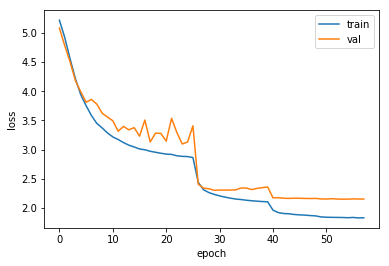

In [12]:
epochs = [x[0] for x in all_losses]
plt.plot(epochs, [x[1] for x in all_losses], label='train');
plt.plot(epochs, [x[2] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('loss');

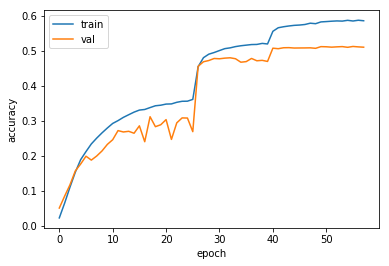

In [13]:
plt.plot(epochs, [x[3] for x in all_losses], label='train');
plt.plot(epochs, [x[4] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('accuracy');

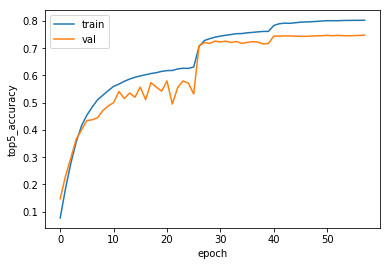

In [14]:
plt.plot(epochs, [x[5] for x in all_losses], label='train');
plt.plot(epochs, [x[6] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('top5_accuracy');

# Save

In [15]:
model.cpu();
torch.save(model.state_dict(), 'model.pytorch_state')